In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import savgol_filter
from statistics import mode

from utils import *

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

dr="/Users/bjackson/Downloads/ps_bundle/data_calibrated"
dr_wind = '/Users/bjackson/Downloads/twins_bundle/data_derived'
# dr="/Users/brian/Downloads/ps_bundle/data_calibrated"
# dr_wind = '/Users/brian/Downloads/twins_bundle/data_derived'

aspect_ratio = 16./9 # On HD projectors nowadays, this is the aspect ratio.
                     # so I make my figures using that ratio so they show up nicely in presentations.
BoiseState_blue = "#0033A0"
BoiseState_orange = "#D64309"

In [2]:
def is_in_catalog(desired_t0, catalog_times, allowed_time_window):
    ind = (np.abs(desired_t0 - catalog_times) < allowed_time_window)
    if(len(catalog_times[ind]) > 0):
        return ind
    else:
        return []

0.890888638920135


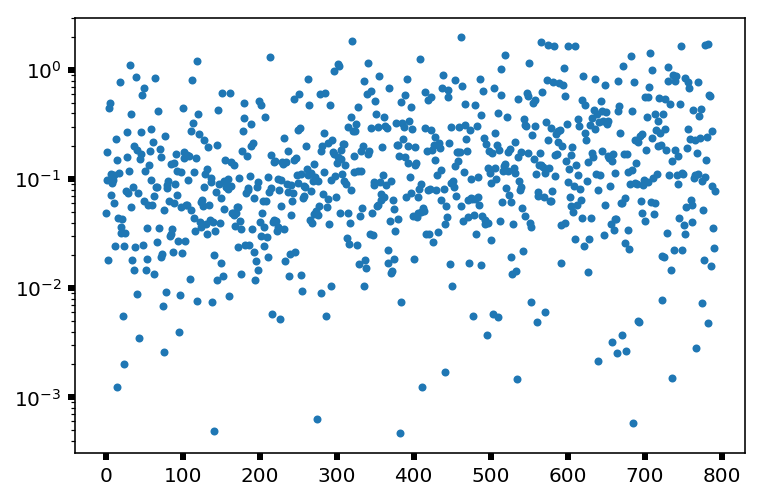

In [29]:
# Comparing to Spiga's detections
our_detections_filename = "all_vortices.csv"
our_detections = np.genfromtxt(our_detections_filename, delimiter=',', names=True)
# print(our_detections.dtype.names)
# ('vortex_number', 'sol', 't0', 't0_unc', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'intercept', 'intercept_unc', 'slope', 'slope_unc', 'convolution')

Spigas_detections_filename = "alldrop_ordered.txt"
Spigas_detections = np.genfromtxt(Spigas_detections_filename, delimiter=';', names=True)
# print(Spigas_detections.dtype.names)
# ('_DROP_', '_LTST_', 'SOL', 'YYYYMMDDTHHMMSSsss', 'RATIO')

# plt.scatter(Spigas_detections['_LTST_'], Spigas_detections['SOL'])
# plt.scatter(our_detections['t0'], our_detections['sol'], alpha=0.25)
# plt.ylim([0, np.max(Spigas_detections['SOL'])])

mutual_detections = []
how_far_off_deltaP = np.array([])
ind = our_detections['sol'] <= np.max(Spigas_detections['SOL'])
for i in range(len(our_detections['sol'][ind])):        
    
    ret_ind = is_in_catalog(our_detections['sol'][ind][i] + our_detections['t0'][ind][i]/24., 
                     Spigas_detections['SOL'] + Spigas_detections['_LTST_']/24., 
                     our_detections['Gamma'][ind][i]/3600./24.)
    
    if(len(ret_ind) > 0):
        mutual_detections.append([our_detections['sol'][ind][i], our_detections['t0'][ind][i], 
                                  our_detections['DeltaP'][ind][i], our_detections['DeltaP_unc'][ind][i],
                                  Spigas_detections['SOL'][ret_ind][0], Spigas_detections['_LTST_'][ret_ind][0], 
                                  Spigas_detections['_DROP_'][ret_ind][0]])
        how_far_off_deltaP = np.append(how_far_off_deltaP, 
            np.abs(our_detections['DeltaP'][ind][i] + Spigas_detections['_DROP_'][ret_ind][0])/\
            our_detections['DeltaP'][ind][i])
# Among vortices detected before sol 220 (the only ones that Spiga posted), what fraction of my detections did
# Spiga also detect?
# 0.9191176470588235
print(len(mutual_detections)/len(our_detections['sol'][ind]))

plt.semilogy(how_far_off_deltaP, marker='.', ls='')

Number of my detections for this sol:  3
Number of Spiga's detections for this sol: 41
[-0.912]
Number Lorenz's power-law histogram says Spiga should see: 5.224489795918369


/Users/bjackson/research/Active Projects/Recovering-Martian-Dust-Devil-Population/code/utils.py:189: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sol_data = np.genfromtxt(sol_filename[0], delimiter=",", dtype=None, names=True)


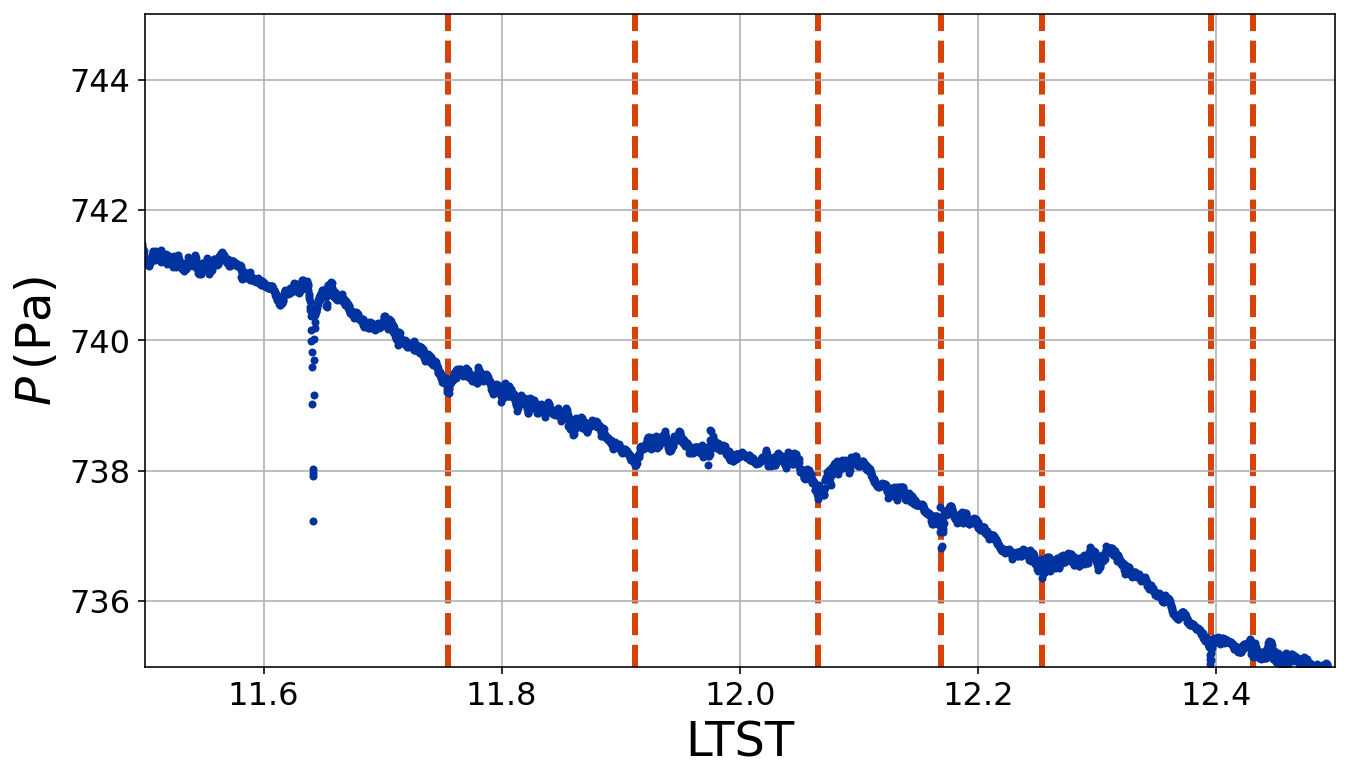

In [8]:
# Looking at some of Spiga's detections that I didn't find

our_detections_filename = "all_vortices.csv"
our_detections = np.genfromtxt(our_detections_filename, delimiter=',', names=True)
# print(our_detections.dtype.names)
# ('vortex_number', 'sol', 't0', 't0_unc', 'DeltaP', 'DeltaP_unc', 'Gamma', 'Gamma_unc', 'intercept', 'intercept_unc', 'slope', 'slope_unc', 'convolution')

Spigas_detections_filename = "alldrop_ordered.txt"
Spigas_detections = np.genfromtxt(Spigas_detections_filename, delimiter=';', names=True)

missed_detections = []
for i in range(len(Spigas_detections['SOL'])):

    # Spiga gives his LTST values to three decimal places, meaning a 3.6 second precision
    ret_ind = is_in_catalog(Spigas_detections['SOL'][i] + Spigas_detections['_LTST_'][i]/24., 
                            our_detections['sol'] + our_detections['t0']/24., 5./3600./24.)

    if(len(ret_ind) == 0):
        missed_detections.append(i)
        
sols = Spigas_detections['SOL'][missed_detections]
drops = Spigas_detections['_DROP_'][missed_detections]
cur_sol = mode(sols).mode
print("Number of my detections for this sol: ", len(our_detections['sol'][our_detections['sol'] == cur_sol]))
ind = sols == cur_sol
print("Number of Spiga's detections for this sol:", len(sols[ind]))
print(drops[ind][drops[ind] <= -0.8])

# Lorenz reports 1 vortex for sol 33, has a threshold for Delta P = 0.8 Pa, where Spiga's is 0.35 Pa.
# Lorenz reports a cumulative power-law index of -2.
print("Number Lorenz's power-law histogram says Spiga should see:", (0.8/0.35)**2)

# ind = missed_detections[ind]
LTST, LTST_and_sol, sol_data = retrieve_data(cur_sol, dr=dr)

fig = plt.figure(figsize=(6*16./9, 6))
ax = fig.add_subplot(111)

x = LTST
y = sol_data['PRESSURE']

filter_window = int(1000./3600./(x[1] - x[0]))
filtered_y = y - savgol_filter(y, filter_window, 0)

ax.plot(x, y, marker='.', ls='', color=BoiseState_blue)
for i in range(len(Spigas_detections['SOL'][missed_detections][ind])):
    ax.axvline(Spigas_detections['_LTST_'][missed_detections][ind][i], color=BoiseState_orange, lw=3, ls='--', zorder=-1)

ax.set_xlim([11.5, 12.5])
ax.set_ylim([735, 745])
ax.tick_params(labelsize=16)
ax.set_xlabel("LTST", fontsize=24)
ax.set_ylabel(r'$P\,\left({\rm Pa}\right)$', fontsize=24)
ax.grid(True)
# ax.text(13.01, 730.1, "Sol %s" % int(cur_sol), fontsize=36)

# fig.savefig("../figures/Spiga_Detections_Example_sol%s.png" % int(cur_sol), dpi=500, bbox_inches="tight")

0.7668997668997669


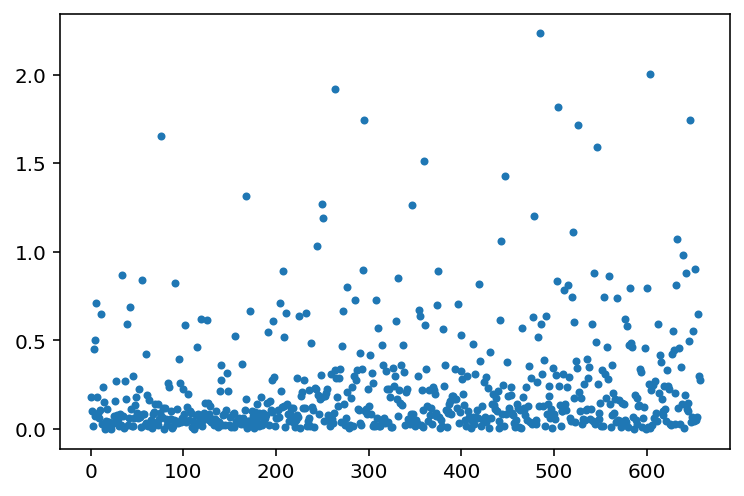

In [3]:
# Comparing to Lorenz's detections
our_detections_filename = "all_vortices.csv"
our_detections = np.genfromtxt(our_detections_filename, delimiter=',', names=True)

Lorenz_detections_filename = "insight_vortex_catalog_000_390_v1.csv"
Lorenz_detections = np.genfromtxt(Lorenz_detections_filename, delimiter=',', names=True)
# ('Num', 'Sol', 'LTST', 'DP', 'Nwind', 'Wmax', 'Wbef', 'Waftr', 'Wdir', 'Atck', 'Dcay', 'Wdth', 'Solar', 'Nsolr', 'Sdip', 'MinT1', 'MaxT1', 'Press', 'Ls', 'LMST', 'UTC')

mutual_detections = []
how_far_off_deltaP = np.array([])
ind = our_detections['sol'] <= np.max(Lorenz_detections['Sol'])
for i in range(len(our_detections['sol'][ind])):    
    oind = (our_detections['sol'][ind][i] == Lorenz_detections['Sol']) &\
        (np.abs(our_detections['t0'][ind][i] - Lorenz_detections['LTST']) < 0.1)
    
    if(len(Lorenz_detections['LTST'][oind]) > 0):
        mutual_detections.append([our_detections['sol'][ind][i], our_detections['t0'][ind][i], 
                                  our_detections['DeltaP'][ind][i], our_detections['DeltaP_unc'][ind][i],
                                  Lorenz_detections['Sol'][oind][0], Lorenz_detections['LTST'][oind][0], 
                                  Lorenz_detections['DP'][oind][0]])
        how_far_off_deltaP = np.append(how_far_off_deltaP, 
            np.abs(our_detections['DeltaP'][ind][i] - Lorenz_detections['DP'][oind][0])/\
            our_detections['DeltaP'][ind][i])
# Among vortices detected before sol 220 (the only ones that Spiga posted), what fraction of my detections did
# Spiga also detect?
# 0.9191176470588235
print(len(mutual_detections)/len(our_detections['sol'][ind]))

plt.plot(how_far_off_deltaP, marker='.', ls='')

In [14]:
Lorenz_detections_filename = "insight_vortex_catalog_000_390_v1.csv"
Lorenz_detections = np.genfromtxt(Lorenz_detections_filename, delimiter=',', names=True)

num_sols = len(np.unique(Lorenz_detections['Sol']))
num_vortices = len(Lorenz_detections)

print(num_sols, num_vortices, num_vortices/num_sols, num_vortices/num_sols*10)

299 853 2.8528428093645486 28.528428093645488


In [21]:
# Ellehoj had a threshold of 0.3 Pa, Lorenz had 0.8 Pa with a power-law index for the cum hist of -2.

num_sols_Phoenix = 151 

print((0.8/0.3)**2*num_vortices/num_sols*num_sols_Phoenix)

3063.319212188778
84352.85618729098


In [20]:
# And then comparing to Spiga's detections

num_vortices_Spiga = 6046

print((0.8/0.35)**2*num_vortices)
print((0.35/0.8)**2.5*num_vortices_Spiga)

4456.489795918368
765.4437586993446


[-2.70053928 -0.58762367]


<ipython-input-95-b73f1fa282c1>:16: RuntimeWarning: divide by zero encountered in log10
  ind = (Ellehoj_bins > 0.) & (np.isfinite(np.log10(Ellehoj_cum_hst)))


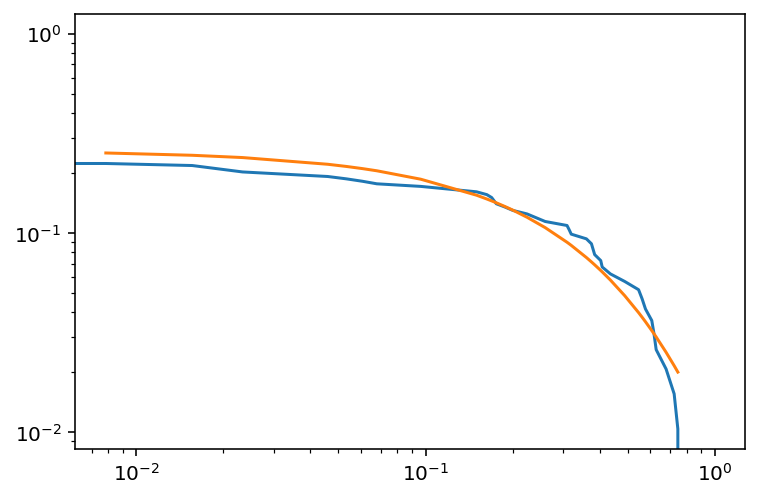

In [95]:
# Ellehoj+ (2010 - https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2009JE003413) data
filename = "Ellehoj2010_Table1_deltaP-Gamma.txt"
Ellehoj_data = np.genfromtxt(filename, delimiter='\t', names=["Delta_P", "Gamma"])

ind = Ellehoj_data["Delta_P"] > 0.5
x = np.log10(Ellehoj_data["Delta_P"][ind])

ind = np.argsort(x)
Ellehoj_bins = np.unique(x[ind])

Ellehoj_hst, _ = np.histogram(x, bins=np.unique([-np.inf, *Ellehoj_bins]))
Ellehoj_cum_hst = len(x) - np.cumsum(Ellehoj_hst)
Ellehoj_cum_hst = Ellehoj_cum_hst / len(x)

plt.semilogy(Ellehoj_bins/np.max(Ellehoj_bins), Ellehoj_cum_hst)
ind = (Ellehoj_bins > 0.) & (np.isfinite(np.log10(Ellehoj_cum_hst)))

coeffs = np.polyfit(Ellehoj_bins[ind], np.log10(Ellehoj_cum_hst[ind]), 1)
print(coeffs)
plt.loglog(Ellehoj_bins[ind]/np.max(Ellehoj_bins), 10.**(np.polyval(coeffs, Ellehoj_bins[ind])))

number of original vortices:  1034
[-0.84412981  0.26033402]
[-2.70053928 -0.58762367]


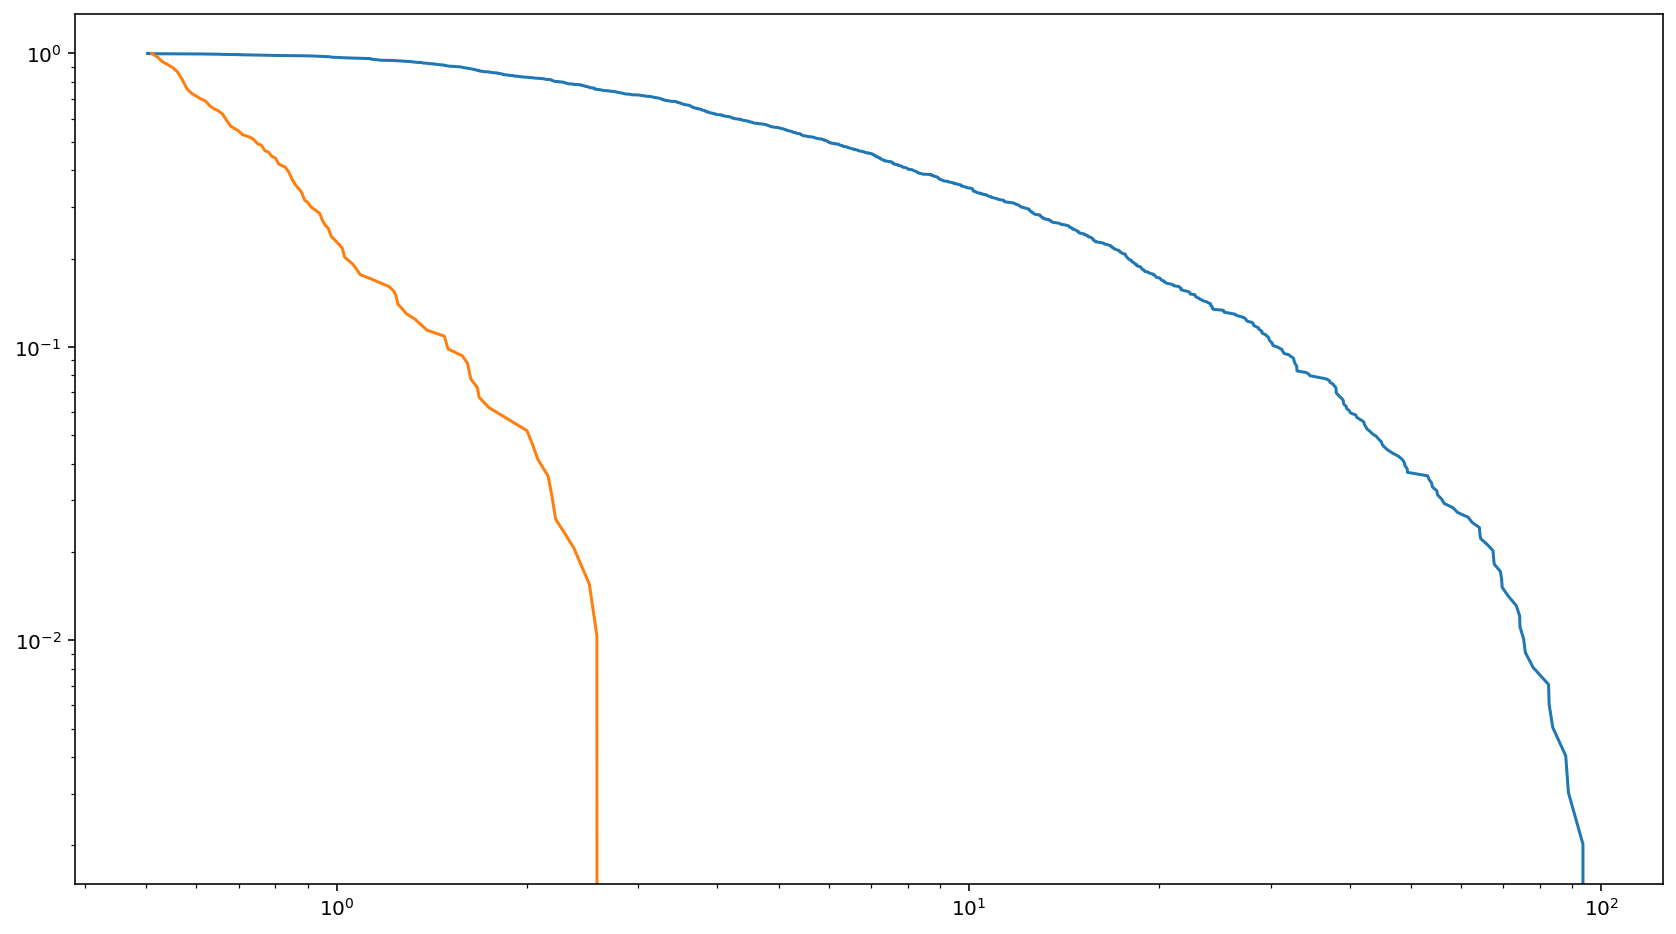

In [106]:
# Ellehoj's population falls off much more steeply as Delta P increases.

def line(x, m, b):
    return m*x + b

Gamma_min = 0.5
Gamma_max = 100
P_min = 0.1

filename = "all_vortices.csv"
data = np.genfromtxt(filename, delimiter=',', names=True)

print("number of original vortices: ", len(data))

fig = plt.figure(figsize=(8*aspect_ratio, 8))
ax = fig.add_subplot(111)

# Toss the ones at either end
ind = (data['Gamma'] > Gamma_min) & (data['Gamma'] < Gamma_max) & (data['DeltaP'] > P_min)
x = np.log10(data['Gamma'][ind])

ind = np.argsort(x)
our_bins = np.unique(x[ind])

our_hst, _ = np.histogram(x, bins=np.unique([-np.inf, *our_bins]))
our_cum_hst = len(x) - np.cumsum(our_hst)
our_cum_hst = our_cum_hst / len(x)

# our_x = (our_bins - np.min(our_bins))/(np.max(our_bins) - np.min(our_bins))
our_x = our_bins
plt.loglog(10**our_x, our_cum_hst)
ind = (our_bins > 0.) & (our_cum_hst > 0)
coeffs = np.polyfit(our_x[ind], np.log10(our_cum_hst[ind]), 1)
print(coeffs)
# plt.semilogy(our_bins[ind], 10.**(np.polyval(coeffs, our_bins[ind])))

# Ellehoj_x = (Ellehoj_bins - np.min(Ellehoj_bins))/(np.max(Ellehoj_bins) - np.min(Ellehoj_bins))
Ellehoj_x = Ellehoj_bins
plt.loglog(10**Ellehoj_x, Ellehoj_cum_hst)
ind = (Ellehoj_bins > 0.) & (Ellehoj_cum_hst > 0)
coeffs = np.polyfit(Ellehoj_x[ind], np.log10(Ellehoj_cum_hst[ind]), 1)
print(coeffs)
# plt.semilogy(Ellehoj_bins[ind], 10.**(np.polyval(coeffs, Ellehoj_bins[ind])))